In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Load some raw resting state data from HCP

In [36]:
import torch
from os.path import expanduser
from torch.utils.data import DataLoader

from data import get_dataset
from model import VAE

train_dataset, test_dataset, mask = get_dataset(in_memory=True)

test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = VAE()
name = 'vae_e_11_loss_4.0705e+03.pkl'
model.load_state_dict(torch.load(expanduser('~/output/deep-fmri/%s' % name)))

model = model.to(device)
mask = mask.to(device)
data = test_dataset[0][None, ...]
data = data.to(device)
recs = []
latents = []
with torch.no_grad():
    for this_data in test_loader:
        this_data = this_data.to(device)
        rec, penalty = model(this_data)
        latent, _ = model.encoder(this_data)
        latents.append(latent)
        recs.append(rec)
recs = torch.cat(recs, dim=0)
latent = torch.cat(latents, dim=0)
recs = recs.masked_fill_(mask[None, None, ...] ^ 1, 0.)
recs = recs.to('cpu').numpy()
latent = latent.to('cpu').numpy()

In [24]:
test_data = torch.cat([this_data for this_data in test_loader]).numpy()

In [5]:
test_data.shape

(300, 1, 91, 109, 91)

In [6]:
recs.shape

(300, 1, 91, 109, 91)

## Find the dynamic range and clip the outliers (when plotting)

In [25]:
all_test_voxels = test_data.ravel()
all_test_voxels.shape

(270788700,)

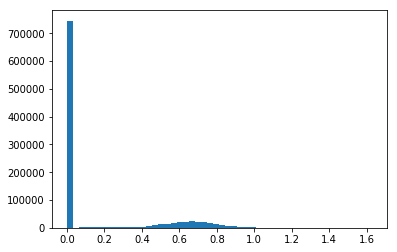

In [26]:
rng = np.random.RandomState(42)
subsample_idx = rng.randint(0, all_test_voxels.size - 1, size=int(1e6))
test_voxels_subsample = all_test_voxels[subsample_idx] 
plt.hist(test_voxels_subsample, bins=50);

In [27]:
vmin, vmax = np.percentile(test_voxels_subsample, [0, 99.9])
vmin, vmax

(0.0, 1.0435531356334722)

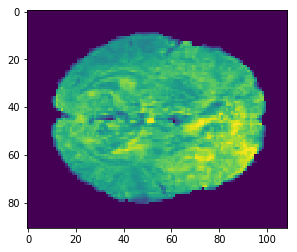

In [28]:
frame_idx = 0
channel_idx = 0
cut_idx = 40

plt.imshow(test_data[frame_idx, channel_idx, :, :, cut_idx], vmax=vmax);

## Generate a movie of the test bold signal

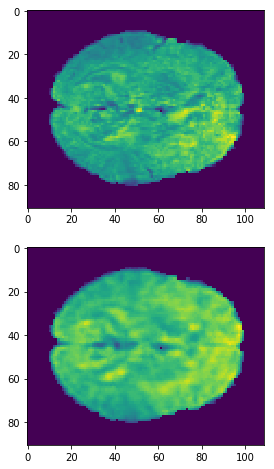

In [32]:
def make_animation(frames, interval=200, fig=None):
    if fig is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    im1 = ax1.imshow(frames[0][0], animated=True)
    im2 = ax2.imshow(frames[0][1], animated=True)

    def updatefig(frame):
        im1.set_array(frame[0])
        im2.set_array(frame[1])
        return im1, im2

    return animation.FuncAnimation(fig, updatefig, frames=frames,
                                   interval=interval, blit=True)


anim = make_animation(list(zip(test_data[:, channel_idx, :, :, cut_idx], recs[:, channel_idx, :, :, cut_idx])))

In [33]:
HTML(anim.to_html5_video())

# Latent space exploration

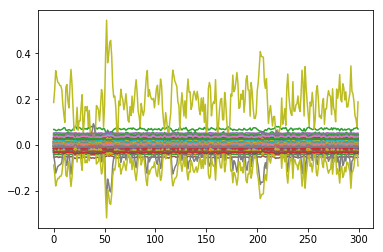

In [43]:
fig = plt.figure()
lines = plt.plot(range(300), latent)

In [ ]:
- loss / penalty reweight
- residual prediction
- downsampling + smoothing
- train comparison
